# Import các thư viện

In [8]:
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import tensorflow as tf


# Load data

In [2]:
df = pd.read_csv('sonar.csv')
df[:5]

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock


### Chia data thành dữ liệu dự đoán và class

In [46]:
X = df.values[:,:-1].astype('float32')
y = df.values[:,-1]

le = LabelEncoder()
y = le.fit_transform(y).astype('float32')

X.shape, y.shape

((208, 60), (208,))

<BarContainer object of 2 artists>

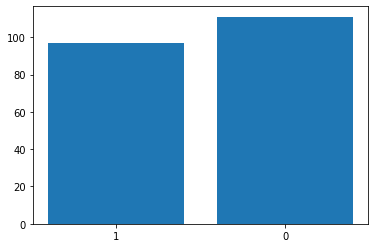

In [36]:
# in ra số class
height = dict(Counter(y)).values()
plt.bar(x=['1','0'], height=height)

In [7]:
def train_model(model, X, y, epochs=100, batch_size=32, **kwargs): # kwargs để thêm các tham số chưa xác định vào khi fit model
    # chia tập data ra thành train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
    # từ train chia thành train và validate
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), **kwargs)

    print()
    # dự đoán trên tập train và tập test
    train_acc = model.evaluate(X_train, y_train)[1]
    test_acc = model.evaluate(X_test, y_test)[1]
    print('Độ chính xác trên tập training: {}%'.format(round(train_acc*100, 6)))
    print('Độ chính xác trên tập test: {}%'.format(round(test_acc*100, 6)))
    
    print()
    # vẽ đồ thị độ chính xác
    legend = ['train', 'valid']
    
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(legend, loc='upper left')
    plt.show()

# Định nghĩa model bình thường

### Model bị overfit do độ chính xác trên train là 100% nhưng test chỉ 85%
Chênh lệch 15%

Epoch 1/100
5/5 [==============================] - 1s 34ms/step - loss: 0.6917 - accuracy: 0.4966 - val_loss: 0.6766 - val_accuracy: 0.6667
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6772 - accuracy: 0.6069 - val_loss: 0.6719 - val_accuracy: 0.7619
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6651 - accuracy: 0.6897 - val_loss: 0.6605 - val_accuracy: 0.6667
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6541 - accuracy: 0.6345 - val_loss: 0.6449 - val_accuracy: 0.5714
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6427 - accuracy: 0.6483 - val_loss: 0.6310 - val_accuracy: 0.5714
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6291 - accuracy: 0.6897 - val_loss: 0.6197 - val_accuracy: 0.6190
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.6174 - accuracy: 0.7103 - val_loss: 0.6084 - val_accuracy: 0.6667
Epoch 8/100
5/5 [=======

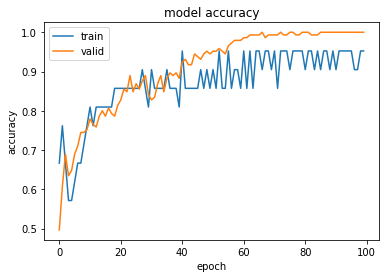

In [8]:
model1 = Sequential([
    Dense(64, input_dim=X.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_model(model1, X, y)

# Định nghĩa model sử dụng các phương pháp hạn chế overfit

### Sử dụng callback early stopping để dừng lại khi lỗi bắt đầu lớn dần

In [12]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

### Thêm các lớp dropout để "bỏ học" các neural ngẫu nhiên (0.4 nghĩa là bỏ học 40% trong tổng 100% neural)
Chênh lệch còn 7%

Epoch 1/100
5/5 [==============================] - 1s 37ms/step - loss: 0.7531 - accuracy: 0.4621 - val_loss: 0.6833 - val_accuracy: 0.4762
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.7144 - accuracy: 0.4966 - val_loss: 0.6776 - val_accuracy: 0.6190
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 0.7022 - accuracy: 0.5310 - val_loss: 0.6780 - val_accuracy: 0.6190
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.7020 - accuracy: 0.5310 - val_loss: 0.6763 - val_accuracy: 0.6190
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6894 - accuracy: 0.5448 - val_loss: 0.6774 - val_accuracy: 0.6190
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 0.6883 - accuracy: 0.5379 - val_loss: 0.6757 - val_accuracy: 0.6190
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6959 - accuracy: 0.4897 - val_loss: 0.6756 - val_accuracy: 0.6667
Epoch 8/100
5/5 [===

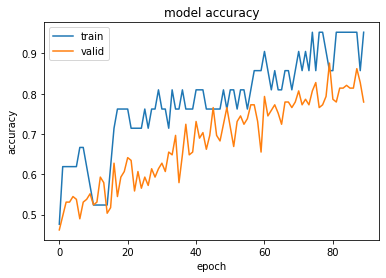

In [13]:
model2 = Sequential([
    Dense(64, input_dim=X.shape[1], activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_model(model2, X, y, callbacks=[early_stopping])

### Sử dụng bộ điều chỉnh tham số L2
Chênh lệch xấp xỉ 5%

Epoch 1/100
5/5 [==============================] - 1s 43ms/step - loss: 1.9678 - accuracy: 0.5241 - val_loss: 1.9189 - val_accuracy: 0.5714
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 1.8941 - accuracy: 0.6621 - val_loss: 1.8522 - val_accuracy: 0.7143
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 1.8258 - accuracy: 0.6966 - val_loss: 1.7850 - val_accuracy: 0.6667
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 1.7609 - accuracy: 0.6483 - val_loss: 1.7228 - val_accuracy: 0.6190
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 1.6995 - accuracy: 0.6759 - val_loss: 1.6669 - val_accuracy: 0.6190
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 1.6410 - accuracy: 0.7172 - val_loss: 1.6137 - val_accuracy: 0.6667
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 1.5849 - accuracy: 0.7379 - val_loss: 1.5570 - val_accuracy: 0.7143
Epoch 8/100
5/5 [====

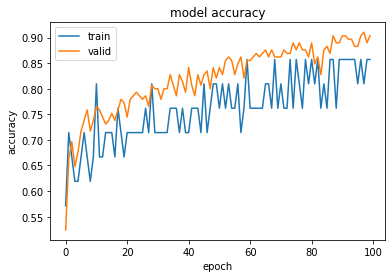

In [14]:
model3 = Sequential([
    Dense(64, input_dim=X.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    Dense(1, kernel_regularizer=regularizers.l2(0.01), activation='sigmoid')
])
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_model(model3, X, y, callbacks=[early_stopping])

### Kết hợp sử dụng nhiều cách như trên
Chênh lệch xấp xỉ 2%

Epoch 1/100
5/5 [==============================] - 1s 45ms/step - loss: 1.9762 - accuracy: 0.4828 - val_loss: 1.9227 - val_accuracy: 0.5714
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 1.9063 - accuracy: 0.5172 - val_loss: 1.8636 - val_accuracy: 0.5238
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 1.8517 - accuracy: 0.4828 - val_loss: 1.8068 - val_accuracy: 0.5238
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 1.7767 - accuracy: 0.6069 - val_loss: 1.7506 - val_accuracy: 0.5238
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 1.7301 - accuracy: 0.5379 - val_loss: 1.6970 - val_accuracy: 0.6190
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 1.6695 - accuracy: 0.5931 - val_loss: 1.6450 - val_accuracy: 0.6190
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 1.6257 - accuracy: 0.5172 - val_loss: 1.5952 - val_accuracy: 0.5714
Epoch 8/100
5/5 [===

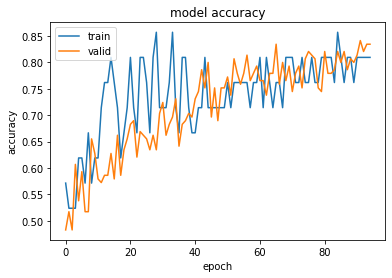

In [16]:
# Early stopping, Dropout, L2
model4 = Sequential([
    Dense(64, input_dim=X.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    Dropout(0.25),
    Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    Dropout(0.25),
    Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    Dropout(0.2),
    Dense(1, kernel_regularizer=regularizers.l2(0.01), activation='sigmoid')
])
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_model(model4, X, y, callbacks=[early_stopping])

### Sử dụng K-fold để đánh giá model
Phương pháp này thường được dùng trên bộ dữ liệu nhỏ

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
# k-fold cross validation 
from sklearn.model_selection import KFold

num_folds = 10
# Khởi tạo K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True) # bộ dữ liệu sẽ chia thành 10 bộ train test khác nhau

# đánh giá model sử dụng K-fold Cross Validation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []

acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(X, y):
    # định nghĩa model
    model = Sequential([
        Dense(64, input_dim=X.shape[1], kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dropout(0.25),
        Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dropout(0.25),
        Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
        Dropout(0.2),
        Dense(1, kernel_regularizer=regularizers.l2(0.01), activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(f'Training for fold {fold_no} ...')

    history = model.fit(X[train], y[train],
                batch_size=32,
                epochs=100,
                verbose = 0) # không hiện ra lúc fit

    # Đánh giá model trên tập train
    train_scores = model.evaluate(X[train], y[train], verbose=0)
    train_loss_per_fold.append(train_scores[0])
    train_acc_per_fold.append(train_scores[1] * 100) 
    # Đánh giá model trên tập test
    scores = model.evaluate(X[test], y[test], verbose=0)
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1] * 100)    

    # Index của fold tiếp theo
    fold_no += 1



Training for fold 1 ...
Training for fold 2 ...
Training for fold 3 ...
Training for fold 4 ...
Training for fold 5 ...
Training for fold 6 ...
Training for fold 7 ...
Training for fold 8 ...
Training for fold 9 ...
Training for fold 10 ...


In [62]:
# in ra lỗi và độ chính xác trên mỗi fold
for i in range(len(acc_per_fold)):
    print(f'điểm đánh giá cho fold {i+1}')
    print(f'train loss: {round(train_loss_per_fold[i],3)} - train accuracy: {round(train_acc_per_fold[i],3)}%')
    print(f'test loss : {round(loss_per_fold[i],3)} - test accuracy : {round(acc_per_fold[i],3)}%')


điểm đánh giá cho fold 1
train loss: 0.523 - train accuracy: 89.305%
test loss : 0.578 - test accuracy : 76.19%
điểm đánh giá cho fold 2
train loss: 0.499 - train accuracy: 91.979%
test loss : 0.58 - test accuracy : 80.952%
điểm đánh giá cho fold 3
train loss: 0.496 - train accuracy: 90.909%
test loss : 0.717 - test accuracy : 66.667%
điểm đánh giá cho fold 4
train loss: 0.518 - train accuracy: 87.701%
test loss : 0.468 - test accuracy : 85.714%
điểm đánh giá cho fold 5
train loss: 0.518 - train accuracy: 90.909%
test loss : 0.46 - test accuracy : 95.238%
điểm đánh giá cho fold 6
train loss: 0.485 - train accuracy: 87.166%
test loss : 0.729 - test accuracy : 80.952%
điểm đánh giá cho fold 7
train loss: 0.495 - train accuracy: 89.305%
test loss : 0.746 - test accuracy : 66.667%
điểm đánh giá cho fold 8
train loss: 0.512 - train accuracy: 88.77%
test loss : 0.557 - test accuracy : 80.952%
điểm đánh giá cho fold 9
train loss: 0.518 - train accuracy: 87.766%
test loss : 0.487 - test accura

In [63]:
# in ra Trung bình lỗi và độ chinh xác cho toàn bộ fold
print("Trung bình lỗi và độ chinh xác cho toàn bộ fold")
print(f'Train Accuracy: {np.mean(train_acc_per_fold)} (+- {np.std(train_acc_per_fold)})')
print(f'train Loss: {np.mean(train_loss_per_fold)}')

print(f'Test Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'Test Loss: {np.mean(loss_per_fold)}')

Trung bình lỗi và độ chinh xác cho toàn bộ fold
Train Accuracy: 89.26385223865509 (+- 1.4936112037161562)
train Loss: 0.5057226598262787
Test Accuracy: 81.83333396911621 (+- 9.638622378633707)
Test Loss: 0.5999137580394744


In [ ]:
# ở đây sau khi sử dụng cross validate ta thường sẽ làm 2 cách sau để chọn model tốt nhất
# 1 là chọn một model ngẫu nhiên hoặc dựa trên tiêu chí nào đó (ví dụ độ chính xác cao nhất thì lưu model lại)
# 2 train cho toàn bộ tập dữ liệu (độ chính xác và lỗi sẽ là trung bình của toàn bộ các fold)